<a href="https://colab.research.google.com/github/sayan0506/Autoencoder-and-PCA-comparative-study/blob/master/MNIST_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MNIST Autoencoder

You will now work on an autoencoder that works on the [MNIST dataset](https://www.tensorflow.org/datasets/catalog/mnist). This will encode the inputs to lower resolution images. The decoder should then be able to generate the original input from this compressed representation.

## Imports

In [3]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
  
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

# **Clear Session**

* Clear the Tensorflow Keras session to reinitialize the keras implementation, so that the current training is not affected by the previous one.
* Use this code before tensorflow implemetation, else if we use it after model definition, it will clear all the allocation or initialization made in that session.

In [12]:
tf.keras.backend.clear_session()

## Prepare the Dataset

You will load the MNIST data from TFDS into train and test sets. Let's first define a preprocessing function for normalizing and flattening the images. Since we'll be training an autoencoder, this will return `image, image` because the input will also be the target or label while training.


In [13]:
def map_image(image, label):
  '''Normalizes and flattens the image. Returns image as input and label.'''
  image = tf.cast(image, dtype=tf.float32)
  image = image / 255.0
  image = tf.reshape(image, shape=(784,))

  return image, image

In [14]:
# Load the train and test sets from TFDS

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 1024

train_dataset = tfds.load('mnist', as_supervised=True, split="train")
train_dataset = train_dataset.map(map_image)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_dataset = tfds.load('mnist', as_supervised=True, split="test")
test_dataset = test_dataset.map(map_image)
test_dataset = test_dataset.batch(BATCH_SIZE).repeat()

## Build the Model

You will now build a simple autoencoder to ingest the data. Like before, the encoder will compress the input and reconstructs it in the decoder output.

In [15]:
def simple_autoencoder(inputs):
  '''Builds the encoder and decoder using Dense layers.'''
  encoder = tf.keras.layers.Dense(units=128, activation='relu')(inputs)
  encoder = tf.keras.layers.Dense(units = 32, activation = 'relu')(encoder)
  decoder = tf.keras.layers.Dense(units= 128, activation='sigmoid')(encoder)
  decoder = tf.keras.layers.Dense(units=784, activation='sigmoid')(decoder)
  
  return encoder, decoder

# set the input shape
inputs =  tf.keras.layers.Input(shape=(784,))

# get the encoder and decoder output
encoder_output, decoder_output = simple_autoencoder(inputs)

# setup the encoder because you will visualize its output later
encoder_model = tf.keras.Model(inputs=inputs, outputs=encoder_output)

# setup the autoencoder
autoencoder_model = tf.keras.Model(inputs=inputs, outputs=decoder_output)
autoencoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               4224      
_________________________________________________________________
dense_3 (Dense)              (None, 784)               101136    
Total params: 209,968
Trainable params: 209,968
Non-trainable params: 0
_________________________________________________________________


## Compile the Model

You will setup the model for training. You can use binary crossentropy to measure the loss between pixel values that range from 0 (black) to 1 (white).

In [16]:
autoencoder_model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss='binary_crossentropy')

## Train the Model

In [18]:
train_steps = 60000 // BATCH_SIZE
simple_auto_history = autoencoder_model.fit(train_dataset, steps_per_epoch=train_steps, epochs=50)

Epoch 1/50
937/937 [==============================] - 4s 4ms/step - loss: 0.1729
Epoch 2/50
937/937 [==============================] - 4s 4ms/step - loss: 0.1491
Epoch 3/50
937/937 [==============================] - 4s 4ms/step - loss: 0.1347
Epoch 4/50
937/937 [==============================] - 3s 4ms/step - loss: 0.1249
Epoch 5/50
937/937 [==============================] - 4s 4ms/step - loss: 0.1182
Epoch 6/50
937/937 [==============================] - 3s 4ms/step - loss: 0.1125
Epoch 7/50
937/937 [==============================] - 3s 4ms/step - loss: 0.1078
Epoch 8/50
937/937 [==============================] - 3s 4ms/step - loss: 0.1047
Epoch 9/50
937/937 [==============================] - 4s 4ms/step - loss: 0.1025
Epoch 10/50
937/937 [==============================] - 4s 4ms/step - loss: 0.1008
Epoch 11/50
937/937 [==============================] - 4s 4ms/step - loss: 0.0993
Epoch 12/50
937/937 [==============================] - 3s 4ms/step - loss: 0.0981
Epoch 13/50
937/937 [====

# Training History

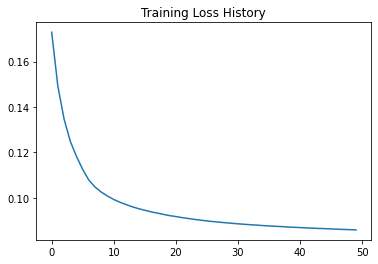

In [34]:
epochs = range(50)
loss = simple_auto_history.history['loss']
plt.plot(epochs, loss)
plt.title('Training Loss History')
plt.show()

## Display sample results

You can now visualize the results. The utility functions below will help in plotting the encoded and decoded values.

In [32]:
def display_one_row(disp_images, offset, shape=(28, 28)):
  '''Display sample outputs in one row.'''
  for idx, test_image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    test_image = np.reshape(test_image, shape)
    plt.imshow(test_image, cmap='gray')


def display_results(disp_input_images, disp_encoded, disp_predicted, enc_shape=(8,4)):
  '''Displays the input, encoded, and decoded output values.'''
  plt.figure(figsize=(15, 5))
  display_one_row(disp_input_images, 0, shape=(28,28,))
  display_one_row(disp_encoded, 10, shape=enc_shape)
  display_one_row(disp_predicted, 20, shape=(28,28,))

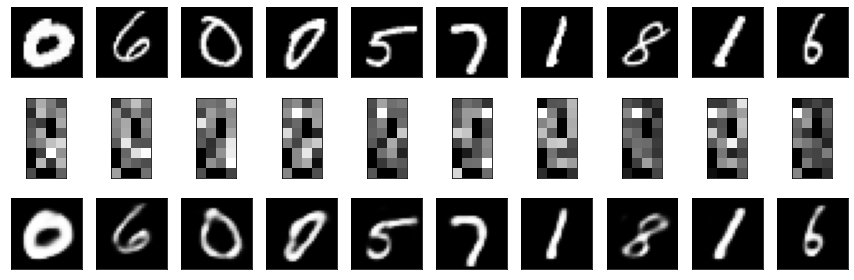

In [33]:
# take 1 batch of the dataset
test_dataset = test_dataset.take(1)

# take the input images and put them in a list
output_samples = []
for input_image, image in tfds.as_numpy(test_dataset):
      output_samples = input_image

# pick 10 random numbers to be used as indices to the list above
idxs = np.random.choice(BATCH_SIZE, size=10)

# get the encoder output
encoded_predicted = encoder_model.predict(test_dataset)

# get a prediction for the test batch
simple_predicted = autoencoder_model.predict(test_dataset)

# display the 10 samples, encodings and decoded values!
display_results(output_samples[idxs], encoded_predicted[idxs], simple_predicted[idxs])

**Awsome, Experimentally we see that, as we gradually dicrease the kernel sized as we get more deeper into the Autoencoder, it performs better.**